# Assigning a 'walk' radius for possible PUDO points of a trip request


Assigning working directory 

In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

Local imports

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from ExMAS.utils import inData as inData

Retrieving config file, graph, and demand 

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 200
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


14-04-21 10:06:28-INFO-Initializing pairwise trip shareability between 200 and 200 trips.
14-04-21 10:06:28-INFO-creating combinations
14-04-21 10:06:28-INFO-39800	 nR*(nR-1)
14-04-21 10:06:29-INFO-Reduction of feasible pairs by 99.81%
14-04-21 10:06:29-INFO-Degree 2 	Completed
14-04-21 10:06:29-INFO-trips to extend at degree 2 : 168
14-04-21 10:06:30-INFO-At degree 2 feasible extensions found out of 2 searched
14-04-21 10:06:30-INFO-Degree 3 	Completed
14-04-21 10:06:30-INFO-trips to extend at degree 3 : 2
14-04-21 10:06:30-INFO-At degree 3 feasible extensions found out of 0 searched
14-04-21 10:06:30-INFO-Degree 4 	Completed
14-04-21 10:06:30-INFO-No more trips to exted at degree 4
14-04-21 10:06:30-INFO-Matching 200 trips to 370 rides in order to minimize u_veh
14-04-21 10:06:30-INFO-Problem solution: Optimal. 
Total costs for single trips:         84,145 
reduced by matching to:               77,719
14-04-21 10:06:31-INFO-Calculations  completed
14-04-21 10:06:31-INFO-DotMap(VehHou

Specifying a walking radius

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

Function that searches for PUDO points that are 5 min walking from O/D of a request. The PUDO locations are stored within a Dataframe that can be easily retrieved later

In [6]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.sblts.requests)), columns = ['pax_id', 'origin', 'destination', \
                               'origin_nodes','destination_nodes','origin_dist','destination_dist'])
    pudo['pax_id'] = _inData.sblts.requests['index']
    pudo['origin'] = _inData.sblts.requests['origin'].tolist()
    pudo['destination'] = _inData.sblts.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist) & (_inData.skim[pudo.iloc[i]['origin']]>0)].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist) & _inData.skim[pudo.iloc[i]['destination']]>0].sort_values()
        pudo.at[i,'origin_nodes'] = list(origins.index)
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        pudo.at[i,'origin_dist']  = origins.tolist()
        pudo.at[i,'destination_dist'] = destinations.tolist()
        
    _inData.pudo = pudo
    
    return _inData


In [7]:
inData = pudo_requests(inData)

PUDO points can be quickly visualised using the function below. 

In [8]:
def plot_pudo_demand(_inData, params, s=10):
    
    fig, ax = ox.plot_graph(_inData.G, figsize=(40, 40), node_size=0, edge_linewidth=0.5,
                            show=False, close=False,
                            edge_color='grey', bgcolor = 'white' )

    for _, r in _inData.pudo.iterrows():
        ax.scatter(_inData.G.nodes[r.origin]['x'], _inData.G.nodes[r.origin]['y'], c='green', s=s*2.5, marker='o')
        ax.scatter(_inData.G.nodes[r.destination]['x'], _inData.G.nodes[r.destination]['y'], c='red', s=s*2.5,marker='>')
        for node in r.origin_nodes:                                                                                         #quite inefficient code
            ax.scatter(_inData.G.nodes[node]['x'], _inData.G.nodes[node]['y'], c='blue', s=s*0.5, marker = 'X',alpha=0.4)
        for node in r.destination_nodes:  
            ax.scatter(_inData.G.nodes[node]['x'], _inData.G.nodes[node]['y'], c='orange', s=s*0.5, marker = 'X',alpha=0.4)
    plt.scatter(_inData.G.nodes[inData.stats['center']]['x'], _inData.G.nodes[_inData.stats['center']]['y'], c='black',
               s=10 * s, marker='+')
    plt.title(
        'Demand in {} with origins marked in green, destinations in orange'.format(params.city))
    plt.show()  

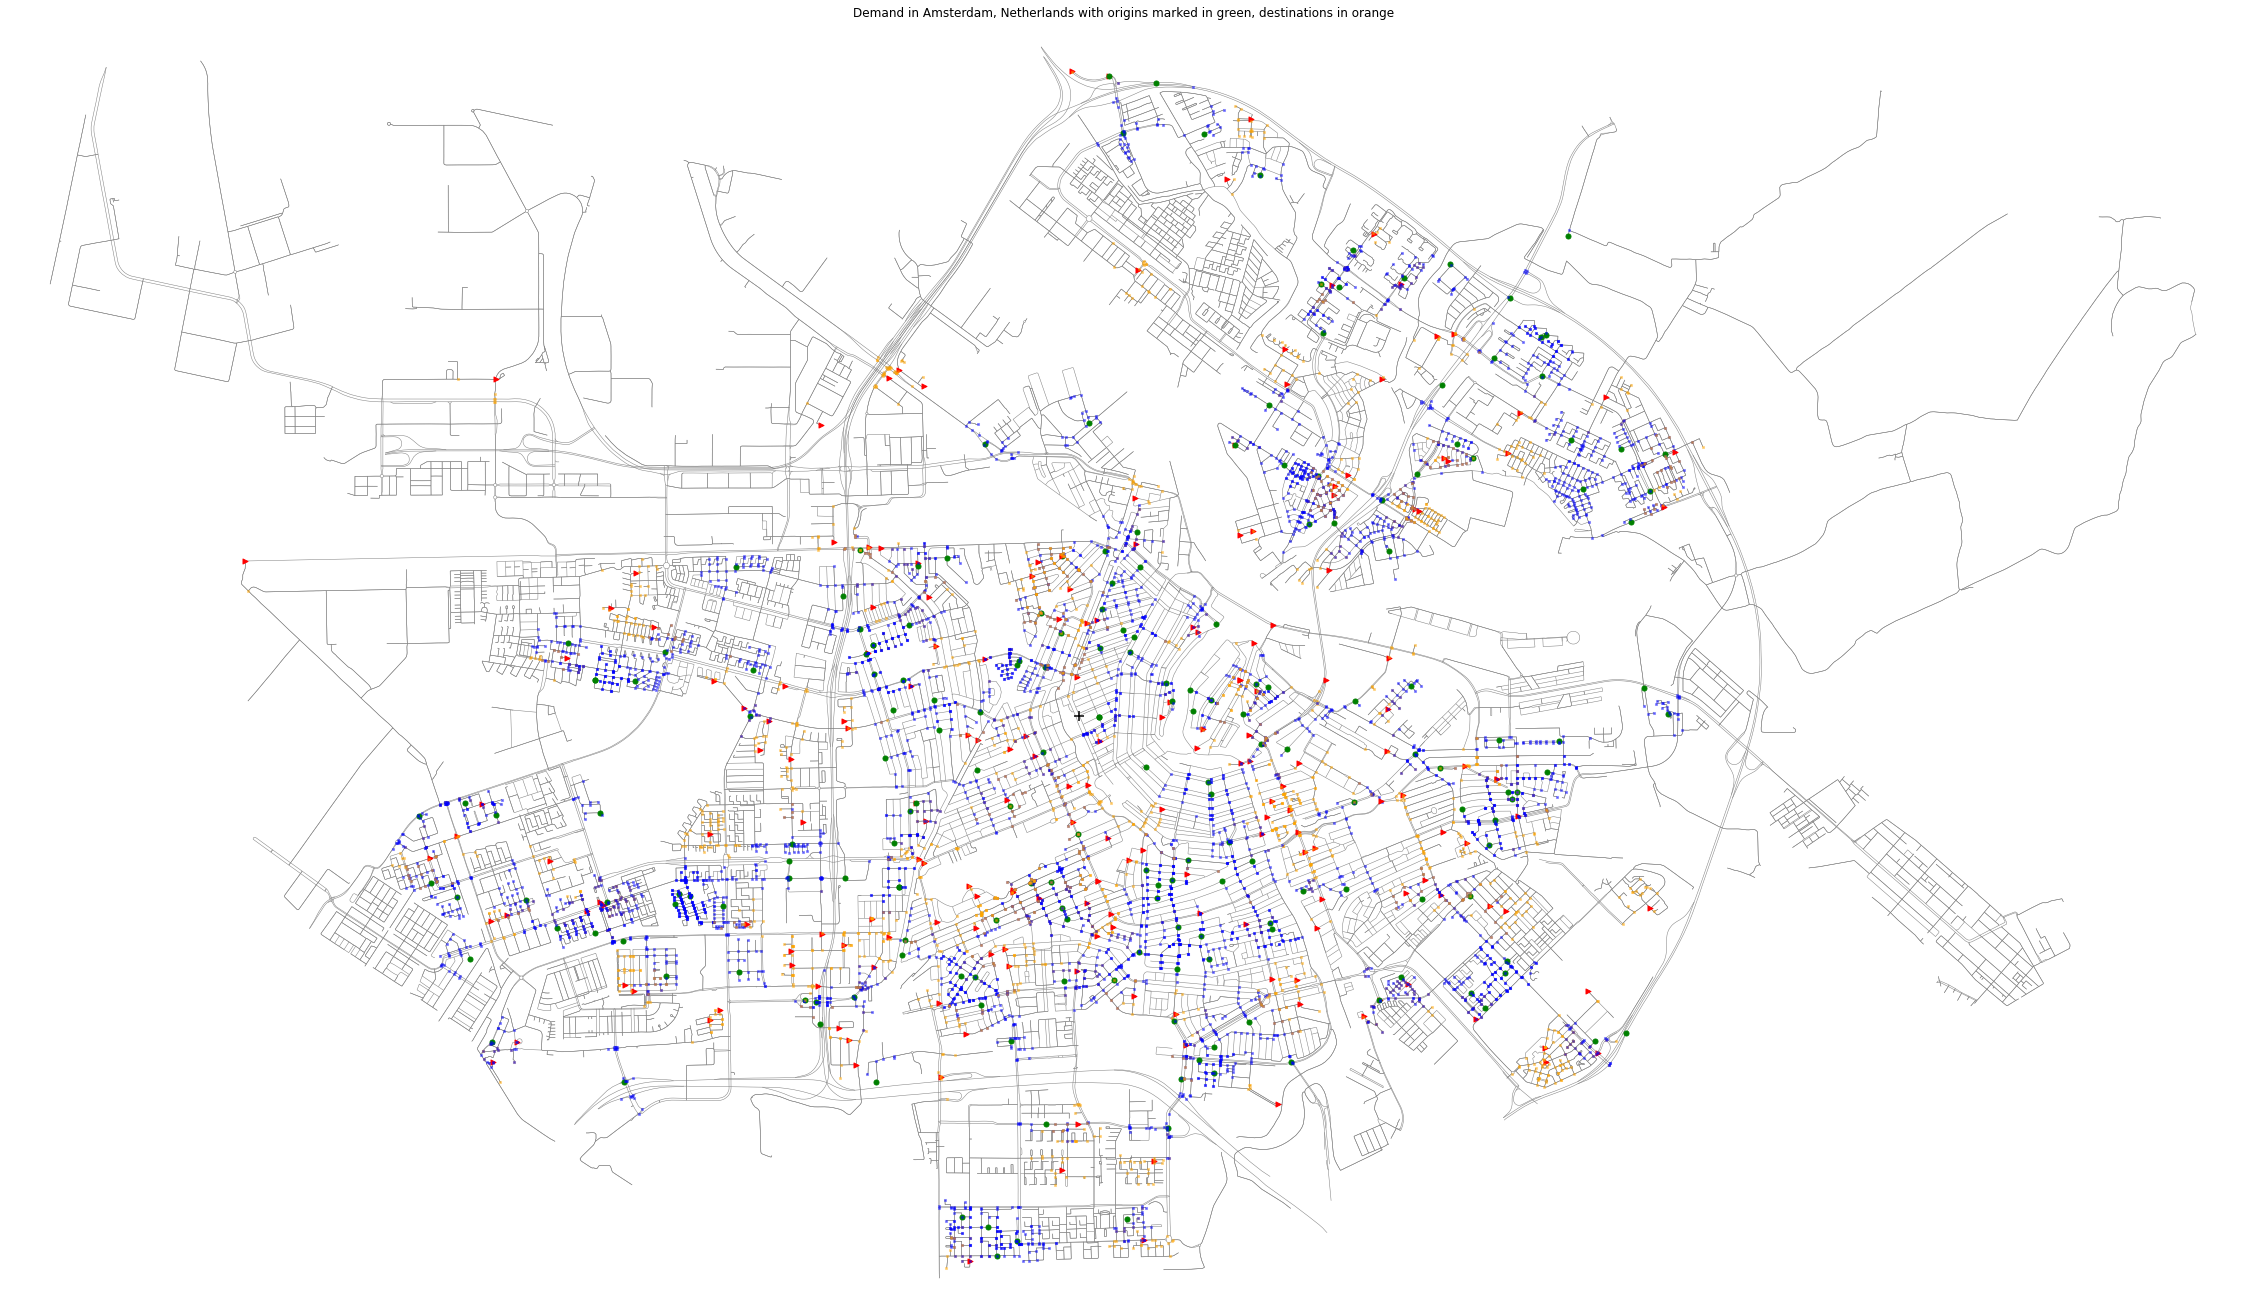

In [9]:
plot_pudo_demand(inData,params)

# Function for plotting the route 

In [10]:
  
def plot_map_rides(inData, ride_indexes, light=True, m_size=30, lw=3, fontsize = 10, figsize = (40,40)):
    import seaborn as sns

    from matplotlib.collections import LineCollection

    def make_schedule(t, r, p):
        columns = ['node', 'times', 'req_id','pudo_nodes', 'od']
        degree = 2 * len(t.indexes)
        df = pd.DataFrame(None, index=range(degree), columns=columns)
        x = t.indexes_orig
        s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in x]
        p = [p.iloc[i].origin_nodes for i in x] + [p.iloc[i].destination_nodes for i in x]      #retrieving pudo locs from PUDO DF
        df.node = pd.Series(s)                                                                                    # adding pudo to DF
        df.pudo_nodes = pd.Series(p)
        df.req_id = x + t.indexes_dest
        df.times = t.times
        df.od = pd.Series(['o'] * len(t.indexes) + ['d'] * len(t.indexes))
        return df


    def add_route(ax, route, color='grey', lw=2, alpha=0.5):
        # plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines = []
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
            # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)

    s = inData.sblts.rides
    r = inData.sblts.requests
    G = inData.G
    p  = inData.pudo
    ts = [make_schedule(s.iloc[ride_index],r,p) for ride_index in ride_indexes]

    # t1 = make_schedule(s.iloc[1], r)
    # t2 = make_schedule(s[s.kind == 20].iloc[1], r)
    #t3 = make_schedule(s[s.kind == 31].iloc[3], r)



    G = inData.G
    fig, ax = ox.plot_graph(G, figsize=figsize, node_size=0, edge_linewidth=0.3,
                            show=False, close=False,
                            edge_color='grey',  bgcolor='white')

    #colors = {1: 'navy', 2: 'teal', 3: 'maroon', 4: 'black', 5: 'green', 6:'teal'}
    colors = sns.color_palette("Set2",6)


    for t in ts:

        orig_points_lats, orig_points_lons, dest_points_lats, dest_points_lons = [], [], [], []
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count += 1
            r = t[t.req_id == i]

            o = r[r.od == 'o'].iloc[0].node
            d = r[r.od == 'd'].iloc[0].node
            
            o_pudo = r[r.od == 'o'].iloc[0].pudo_nodes
            d_pudo = r[r.od == 'd'].iloc[0].pudo_nodes

            if not light:
                ax.annotate('o' + str(i), (G.nodes[o]['x'] * 1.0001, G.nodes[o]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.annotate('d' + str(i), (G.nodes[d]['x'] * 1.0001, G.nodes[d]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
            route = nx.shortest_path(G, o, d, weight='length')
            add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'], s=m_size, c=[colors[deg]], marker='o')
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'], s=m_size, c=[colors[deg]], marker='>')
            for o_p in o_pudo:
                ax.scatter(G.nodes[o_p]['x'], G.nodes[o_p]['y'], s=m_size,alpha = 0.6, c=[colors[deg]], marker='x')
            for d_p in d_pudo:
                ax.scatter(G.nodes[d_p]['x'], G.nodes[d_p]['y'], s=m_size,alpha = 0.6, c=[colors[deg]], marker='x')
        routes = list()  # ride segments
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax, route, color=[colors[deg]], lw=lw, alpha=0.7)
    plt.tight_layout()
    plt.savefig('map.png', dpi = 300)

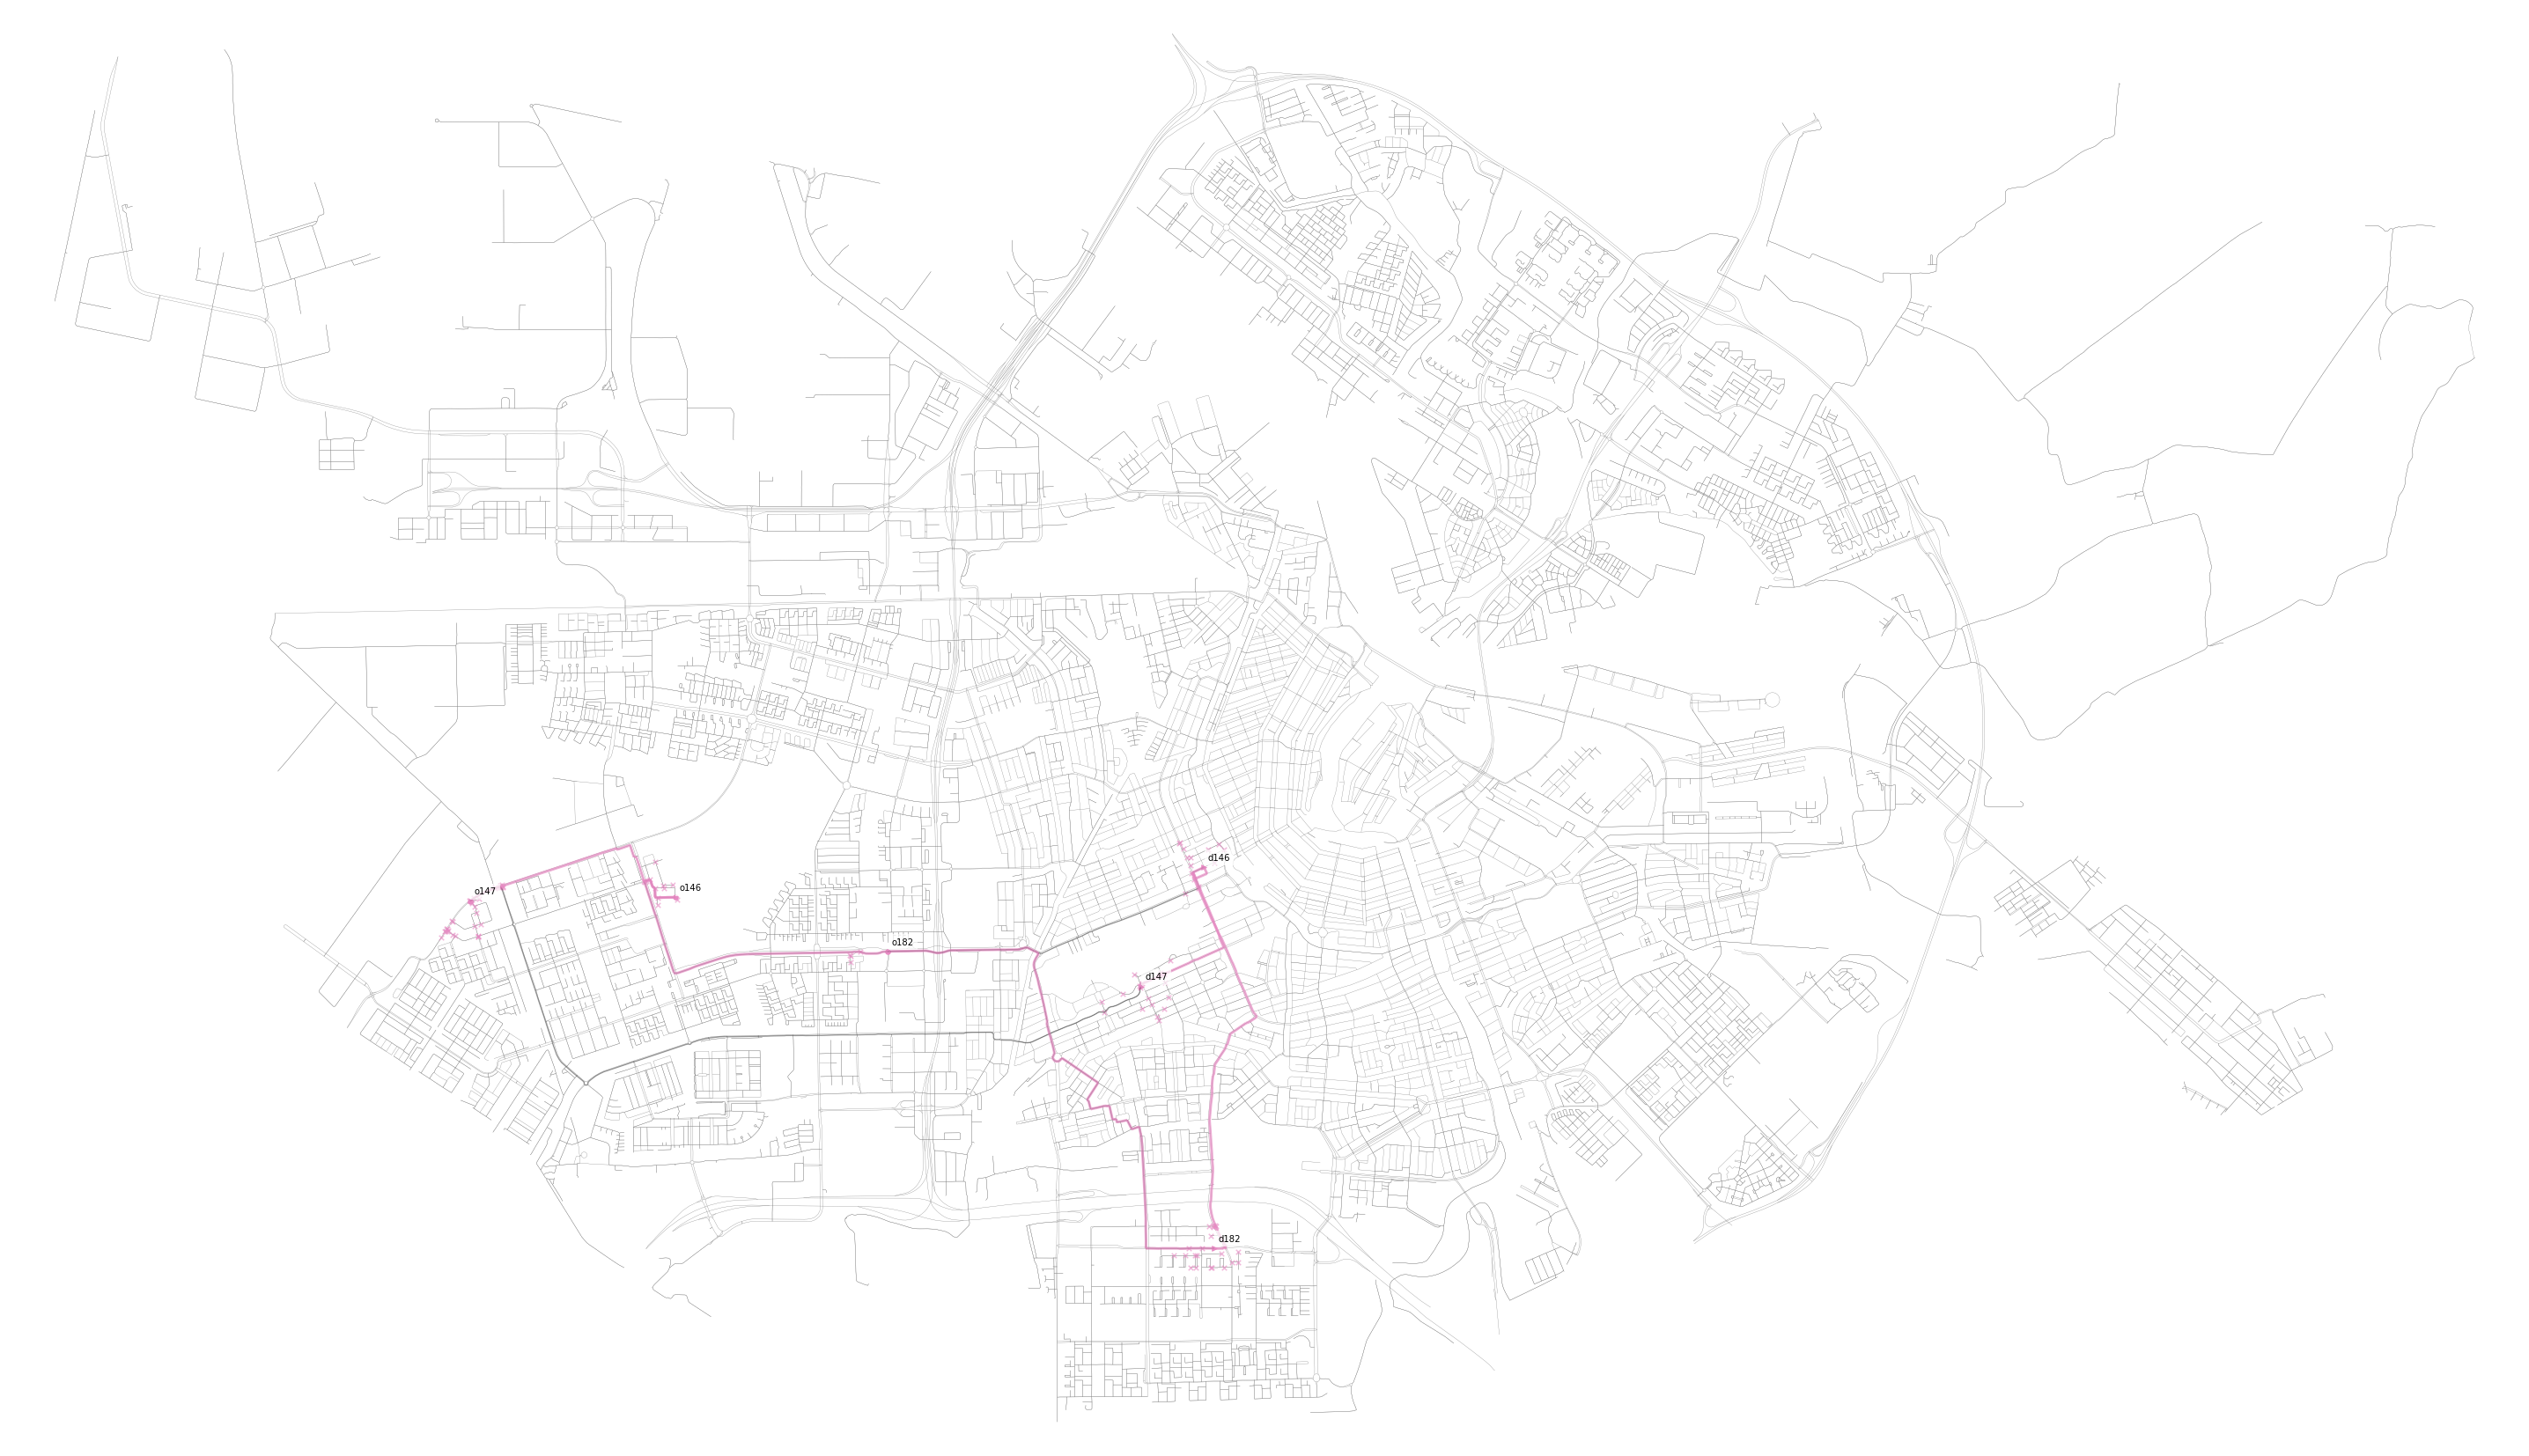

In [18]:
plot_map_rides(inData, [369], light=False, m_size=30, lw=3, fontsize = 10, figsize = (40,40))

Selected highest degree ride -> used as sample ride for optimising

In [12]:
r = inData.sblts.rides[inData.sblts.rides.degree!=1]
r = inData.sblts.rides[inData.sblts.rides.selected == 1]

r = r.iloc[-1]                                                       #last feasbile shared ride selected
r

indexes                                              [147, 146, 182]
u_pax                                                         32.953
u_veh                                                           1718
kind                                                              31
u_paxes            [17.610075, 10.770724999999999, 4.572224999999...
times                              [2922.5, 290, 398, 351, 202, 477]
indexes_orig                                         [147, 146, 182]
indexes_dest                                         [182, 146, 147]
degree                                                           NaN
index                                                            369
lambda_r                                                    0.245498
PassHourTrav_ns                                                 2277
row                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
selected                                                           1
Name: 369, dtype: object

In [26]:
O = inData.pudo.iloc[r.indexes[0]].origin                        #First one picked up from door
D = inData.pudo.iloc[r.indexes_dest[-1]].destination             #Last one dropped at door -> these could be subject to change in the future

o_1 = inData.skim[O].filter(items=inData.pudo.iloc[r.indexes[1]].origin_nodes) #skim of pick up points of second passenger with respect to the first passenger


pudo = pd.DataFrame(columns = ['PUDO_nodes', 'distance'])

In [27]:
o_1.sort_values()

504547507     1837
46349479      1847
46355815      1847
46348762      1866
504575942     1878
46347541      1967
1947419469    2041
46348496      2058
46344601      2063
46342465      2121
46348600      2141
46343732      2257
Name: 46343670, dtype: int64

# Brute-force Search for shortest path

An attempt at going through every possible PUDO for a given origin/destination index. The shortest distance would be taken as the optimal route.

This would result in a very inefficient algorithm, which also why I did not complete it. 

In essence I was trying to create a table that resembles this:



In [ ]:




for nod in o_1.index:
    lst = []
    lst.append(nod)
    dist = o_1[nod]
    for i,j in enumerate(r.indexes[1:]):   
        o = inData.pudo.iloc[j].origin_nodes           #List of pudo origins for a index
    
        if j === r.indexes[-1]                         #are destination indeces alaways `mirrored' to origin indeces? 
            for i,j in enumerate(r.indexes[:-1]):
        
    #if i==0:
                                                    

'''PUDO LOCATIONS           | Distance (m)           #sample table 
------------------------------------------
[node_id_0, node_id_1, ...] | 23550
...                         | ...            '''    
    
    

# Dijkstra algorithm for a simple graph

Dijkstra algorithm would be able to find the global optimium of a given graph. A dijkstra algorithm is already used within osmnx to calulcate shortest path, but something similar would be needed to assess the shortest path of all the nodes. 

If this were to be used, the graph should be set up for all the possible PUDO points


In [ ]:
graph = {'a':{'b':10,'c':3},'b':{'c':1,'d':2}\                                                # sample graph
         ,'c':{'b':4,'d':8,'e':2},'d':{'e':7},'e':{'d':9}}
    
def dijkstra(graph,start,goal):
    shortest_distance ={}              
    predecessor = {}                   
    unseenNodes = graph                                                                       # run through all until every node has been checked
    infinity = float('inf')
    path = []
    
    for node in unseenNodes:
        shortest_distance[node] = infinity                                                    # assigning infinity to nodes in proximity
    shortest_distance[start] = 0    
    
    while unseenNodes:                                                                       # keep running until unseennodes is empty
        minNode = None
        for node in unseenNodes:                                                             # go through the nodes in unseen nodes     
            if minNode is None:
                minNode =node                                                                # first node is the minnode
            elif shortest_distance[node]<shortest_distance[minNode]:                         # assigning new node to minnode
                minNode=node
                
        for childNode, weight in graph[minNode].items():                                     # for current minode, examine connecting nodes 
            if weight + shortest_distance[minNode]<shortest_distance[childNode]:             # if distance from min node shorter than child node, assign child node as min node
                
                shortest_distance[childNode] = weight + shortest_distance[minNode]
                predecessor[childNode] = minNode
                
        unseenNodes.pop(minNode)                                                             # break while loop
        
    currentNode = goal
    while currentNode != start:                                                              # run as long as current node is not equal to start node
        try:
            path.insert(0,currentNode)                                                       # insert nodes that are in shortest path
            currentNode = predecessor[currentNode]
        except KeyError:
            print('Path not reachable')
            break
    
    path.insert(0,start)
    if shortest_distance[goal] != infinity:
        print('Shortest distance is ' + str(shortest_distance[goal]))
        print('and the path is' + str(path))
                
    
dijkstra(graph, 'a', 'd')